In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1


In [2]:
from configs.wavenet_biogas import hparams
hparams = hparams()
print(hparams)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[('batch_size', 800), ('datagen', 'biogas'), ('dilation_channels', 16), ('dilations', [1, 2, 4, 8, 16, 32, 64]), ('filter_width', 2), ('in_seq_len', 258), ('initial_filter_width', 2), ('input_channels', 1), ('input_dim', 1), ('lambd', 1e-10), ('learning_rate', 0.01), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.995), ('norm_epsilon', 1e-12), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('quantization_channels', 100), ('residual_channels', 16), ('sample_rate', 24), ('scalar_input', False), ('skip_channels', 32), ('test_split', 0.1), ('train_split', 0.8), ('use_biases', True), ('val_split', 0.1)]


In [73]:
hparams.num_layers  = 3
hparams.embd_pdrop  = 0.2
hparams.attn_pdrop  = 0.2
hparams.resid_pdrop = 0.2
hparams.num_states  = 16
hparams.num_heads   = 4
hparams.learning_rate = 1e-3
hparams.batch_size = 100
hparams.in_seq_len = 24
hparams.out_seq_len = 24 * 5
hparams.lambd=1e-6

### Define Data Generator

In [46]:
from data_loader.biogas import *
get_fields = 'AT305 AT303 FT202'
get_fields = 'AT305 AT303'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)

In [6]:
from data_loader.sin import *
dataset, dataset_val, dataset_test = load_data(hparams, mode='fixed_frequency', normalise='random_scale_and_offset')
target, inp, mask, x_max = next(iter(dataset))

Added x, y data
Added y_mask data
Added x_max data
Instructions for updating:
Colocations handled automatically by placer.


### Define Model

In [8]:
class GPT(tf.keras.Model):
    '''
    https://github.com/NVIDIA/nv-wavenet/blob/master/pytorch/wavenet.py
    '''
    def __init__(self, params, condition_model=False):
        super(GPT, self).__init__()

        self.num_layers            = params.num_layers
        self.quantization_channels = params.quantization_channels
        self.embd_pdrop            = params.embd_pdrop
        self.attn_pdrop            = params.attn_pdrop
        self.resid_pdrop           = params.resid_pdrop
        self.num_states            = params.num_states
        self.num_heads             = params.num_heads
        
        self.we = tf.get_variable('embedding', [1, self.num_states],
                                  initializer=tf.random_normal_initializer(stddev=0.02))
        #self.embed = tf.keras.layers.Embedding(self.quantization_channels + 1, self.num_states,
                                               #name='embedding')
            # Need an extra channel to create enough buckets e.g. [0-100] Needs 101 channels

        self.attn_layers = []
        self.norm_layers = []
        self.mlp_layers  = []
        for ix in range(self.num_layers):
            self._block(ix)

    ##########################################
    # Build functions
    ##########################################
    def _block(self, ix, scale=False):
        a = self._attn(ix, self.num_states, self.num_heads)
        self.attn_layers.append(a)

        g1 = tf.get_variable('g1_%i' % ix, [self.num_states], initializer=tf.constant_initializer(1))
        b1 = tf.get_variable('b1_%i' % ix, [self.num_states], initializer=tf.constant_initializer(0))
        g2 = tf.get_variable('g2_%i' % ix, [self.num_states], initializer=tf.constant_initializer(1))
        b2 = tf.get_variable('b2_%i' % ix, [self.num_states], initializer=tf.constant_initializer(0))
        self.norm_layers.append({'g1': g1, 'b1': b1, 'g2': g2, 'b2': b2})
        
        m_fc   = tf.keras.layers.Conv1D(self.num_states * 4, 1, name='mlp_fc_%i' % ix, activation='sigmoid')
        m_proj = tf.keras.layers.Conv1D(self.num_states,     1, name='mlp_proj_%i' % ix)
        self.mlp_layers.append({'fc': m_fc, 'proj': m_proj})

        return

    def _attn(self, i, n_state, n_head):
        assert n_state%n_head==0
        layer = {}
        layer['conv']  = tf.keras.layers.Conv1D(n_state*3, kernel_size=1, padding='valid', name='conv_attn_%i' % i)
        layer['resid'] = tf.keras.layers.Conv1D(n_state,   kernel_size=1, padding='valid', name='proj_attn_%i' % i)
        return layer
            
    ##########################################
    # Call functions
    ##########################################
    
    def block(self, x, i, train=False, scale=False):
        a = self.attn(x, i, train=train)
        n = self.norm(x+a, g=self.norm_layers[i]['g1'], b=self.norm_layers[i]['b1'])
        m = self.mlp(n, i)
        h = self.norm(n+m, g=self.norm_layers[i]['g2'], b=self.norm_layers[i]['b2'])
        return h

    def attn(self, x, i, train=False):
        # Convolve input vector
        x = self.attn_layers[i]['conv'](x)

        nm, nx, nf = x.shape.as_list() # Batch size, batch length, num filters
        nf = nf //3                    # Section filters into k, q, v
        nh = self.num_heads            # Num heads
        ns = nf // nh                  # Num split filters
        assert(nf % nh == 0)

        # Extract keys, queries and values
        k, q, v = tf.split(x, 3, 2)
        k = tf.transpose(tf.reshape(k, [nm, nx, nh, ns]), [0, 2, 3, 1])
        q = tf.transpose(tf.reshape(q, [nm, nx, nh, ns]), [0, 2, 1, 3])
        v = tf.transpose(tf.reshape(v, [nm, nx, nh, ns]), [0, 2, 1, 3])
        
        # Attention Calculation
        w = tf.matmul(q, k)
                         
        # Mask Attention
        b = tf.matrix_band_part(tf.ones([nx, nx]), -1, 0)
        b = tf.reshape(b, [1, 1, nx, nx])
        w = w*b + -1e9*(1-b)

        # Apply Attention Weights
        w = tf.nn.softmax(w)
        if train: w = tf.nn.dropout(w, rate=self.attn_pdrop)

        a = tf.matmul(w, v)
        a = tf.reshape(a, [nm, nx, nf])
        
        a = self.attn_layers[i]['resid'](a)
        if train: a = tf.nn.dropout(a, rate=self.resid_pdrop)

        return a
    
    def norm(self, x, g=None, b=None, e=1e-5, axis=[1]):
        u = tf.reduce_mean(x, axis=axis, keep_dims=True)
        s = tf.reduce_mean(tf.square(x-u), axis=axis, keep_dims=True)
        x = (x - u) * tf.rsqrt(s + e)
        if g is not None and b is not None:
            x = x*g + b
        return x
    
    def mlp(self, x, i, train=False):
        x = self.mlp_layers[i]['fc'](x)
        x = self.mlp_layers[i]['proj'](x)
        if train: x = tf.nn.dropout(x, rate=self.resid_pdrop)
        return x
            
    def call(self, inp, mask=None, train=False):
        
        assert(0 <= np.max(inp) <= 1.)
        if train: inp = tf.nn.dropout(inp, rate=self.embd_pdrop)

        for i in range(self.num_layers):
            inp = self.block(inp, i, train=train)
        
        nm, nx, nf = inp.shape.as_list()
        inp = tf.reshape(inp[:, :-1], [-1, self.num_states])
        inp = tf.matmul(inp, self.we, transpose_b=True)
        inp = tf.reshape(inp, [nm, nx-1, -1])
        
        return inp

### Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

In [74]:
model = GPT(hparams)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)
#optimizer = tf.train.RMSPropOptimizer(hparams.learning_rate)

In [77]:
optimizer._lr /= 10

In [ ]:
for epoch in range(1000):
    if epoch % 10 == 0:
        dataset, _, _ = load_data(hparams, normalise='random_scale_and_offset', isVerbose=False)
    losses = []
    for target, inp, mask, x_max in iter(dataset):
        with tf.GradientTape() as tape:
            pred = model(inp, train=True)

            ols_loss = tf.losses.mean_squared_error(inp[:,1:], pred)            
            l2_loss = tf.reduce_sum([tf.reduce_sum(var ** 2) * (1 if var.name.find('bias') == -1 else 0)\
                                     for var in model.trainable_variables]) * hparams.lambd
            
            loss = tf.reduce_sum([ols_loss, l2_loss])
            
        # Update gradients
        variables = model.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        losses.append(loss)
    
    optimizer._lr *= 0.999
    if epoch % 1 == 0:
        print(epoch, ': ', np.round(np.dstack(losses).mean(), 3), np.round(ols_loss, 3), np.round(l2_loss,4))

0 :  0.04 0.039 0.0004
1 :  0.039 0.039 0.0004
2 :  0.039 0.039 0.0004
3 :  0.039 0.039 0.0004
4 :  0.039 0.039 0.0004
5 :  0.039 0.039 0.0004
6 :  0.039 0.039 0.0004
7 :  0.039 0.039 0.0004
8 :  0.039 0.039 0.0004
9 :  0.039 0.038 0.0004
10 :  0.046 0.046 0.0004
11 :  0.046 0.045 0.0004
12 :  0.046 0.046 0.0004
13 :  0.046 0.045 0.0004
14 :  0.045 0.045 0.0004
15 :  0.045 0.045 0.0004
16 :  0.045 0.045 0.0004
17 :  0.045 0.045 0.0004
18 :  0.045 0.045 0.0004
19 :  0.045 0.045 0.0004
20 :  0.049 0.049 0.0004
21 :  0.049 0.048 0.0004
22 :  0.049 0.049 0.0004
23 :  0.049 0.048 0.0004
24 :  0.049 0.048 0.0004
25 :  0.049 0.048 0.0004
26 :  0.049 0.049 0.0004
27 :  0.049 0.048 0.0004
28 :  0.049 0.048 0.0004
29 :  0.049 0.048 0.0004
30 :  0.045 0.045 0.0004
31 :  0.045 0.045 0.0004
32 :  0.045 0.045 0.0004
33 :  0.045 0.045 0.0004
34 :  0.045 0.045 0.0004
35 :  0.045 0.045 0.0004
36 :  0.045 0.045 0.0004
37 :  0.045 0.044 0.0004
38 :  0.045 0.045 0.0004
39 :  0.045 0.045 0.0004
40 :  0.042

In [ ]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = GPT(hparams)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=10, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.show()

model.summary()
trainer.save_model(model, optimizer, dataset_val, hparams, 'seq_multichannel_' + get_fields.replace(' ', '_'))

### Test Hyperparameters

In [39]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

#for _ in range(25):
#   lr = np.random.uniform(-8, -1, 1):
#   nodes = np.floor(2 ** np.random.randint((3,9))):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = EncoderDecoder(hparams.output_channels, hparams.num_layers, hparams.neurons_unit, hparams.batch_size)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 2, verbose=False)
    print('Learning Rate {:.4f} Nodes {} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(\
                lr, nodes, loss*100, accuracy * 100, run_time))
    
    models.append(model_)
    stats.append(stat)

Learning Rate -4.0000 Nodes 32 Loss 0.7740 Accuracy 0.7730 Time 23.2
Learning Rate -3.5000 Nodes 32 Loss 0.1131 Accuracy 0.1121 Time 22.6
Learning Rate -3.0000 Nodes 32 Loss 0.1508 Accuracy 0.1498 Time 22.7
Learning Rate -2.5000 Nodes 32 Loss nan Accuracy nan Time 22.4
Learning Rate -2.0000 Nodes 32 Loss nan Accuracy nan Time 22.5
Learning Rate -1.5000 Nodes 32 Loss nan Accuracy nan Time 22.5
Learning Rate -1.0000 Nodes 32 Loss nan Accuracy nan Time 22.9
Learning Rate -0.5000 Nodes 32 Loss nan Accuracy nan Time 22.6


### Make Predictions

In [57]:
0.003 ** 0.5

0.05477225575051661

In [62]:
target, inp, mask, x_max = next(iter(dataset))

forecast = inp[:8,:]
blank    = tf.zeros_like(forecast[:,-1:])
forecast = tf.concat([forecast, blank], 1)
for n in range(120-12, 120-2):
    pred = model(forecast[:,-120:], train=False)
    forecast = tf.concat([forecast[:,:n+1], pred[:,n:n+1], forecast[:,n+2:]], 1)
    forecast = tf.clip_by_value(forecast,0,1)
    
for n in range(48):
    pred = model(forecast[:,-120:], train=False)
    forecast = tf.concat([forecast[:,:-1], pred[:,-1:], blank], 1)    
    forecast = tf.clip_by_value(forecast,0,1)

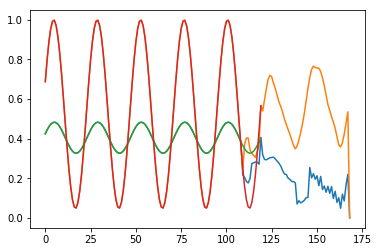

In [66]:
plt.plot(np.squeeze(forecast[:2]).T)
plt.plot(np.squeeze(inp[:2]).T)
plt.show()

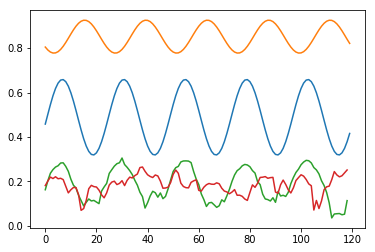

In [60]:
forecast = inp[2:4,:]
pred = model(forecast[:,-120:], train=False)
plt.plot(np.squeeze(forecast).T)
plt.plot(np.squeeze(pred).T)
plt.show()

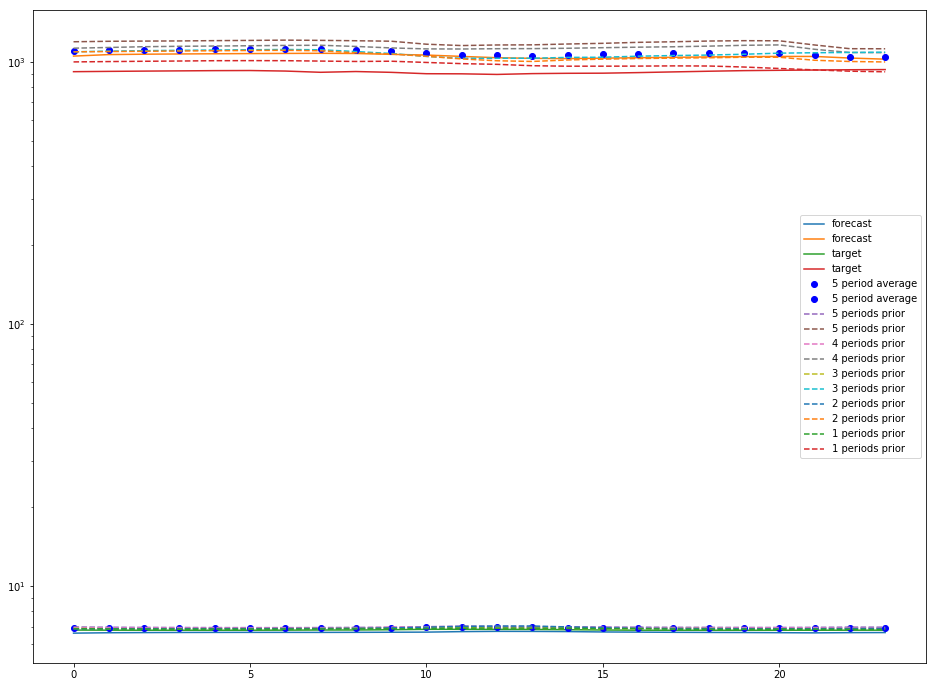

In [53]:
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
forecast = model(inp, mask)
forecast *= x_max
target   *= x_max
inp = np.reshape(inp, [hparams.batch_size, hparams.in_seq_len, hparams.input_dim, hparams.input_channels])
inp *= np.reshape(x_max, [hparams.batch_size,1,1,-1])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(forecast, axis=1), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.sum(inp, axis=0)[:,i], '--', label='%i years prior' % (5-i))

plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,100):
    ax = plt.subplot(10,10,i+1)
    ax.plot(np.squeeze(forecast[:,i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

In [ ]:
l_ = np.sum((forecast.T - np.squeeze(target)[:,:-1]) ** 2, axis=1)
l_.argsort()

In [ ]:
loss = np.mean((forecast.T*8.15 - target[:,1:,0]*8.15) ** 2 / dataset.var(), axis=0)
plt.plot(loss)
plt.show()

## Test Model Accuracy

Run a training session and print training statistics and model structure

[]

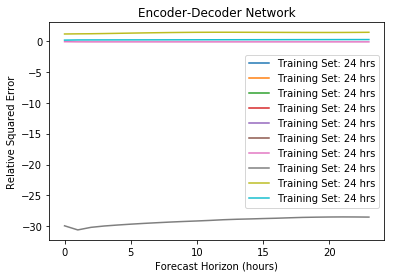

In [50]:
plt.figure()
for t, data in model_accuracy:
    plt.plot(data, label = 'Training Set: %i hrs' % t)
plt.legend()
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('Relative Squared Error')
plt.title('Encoder-Decoder Network')
plt.plot()

In [19]:
model_accuracy = []

Total Accuracy: 0.7796


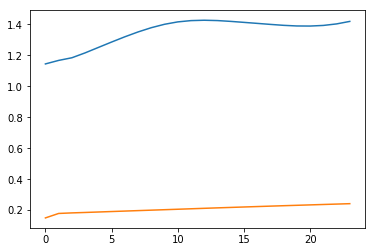

In [49]:
START_POINT = 0
total_accuracy = []
x_variance = x_var(hparams, mode=get_fields)

for i, (inp, target, mask, x_max) in enumerate(dataset_val):
    forecast = model(inp, mask)

    accuracy = (forecast - target) * x_max
    accuracy = accuracy ** 2 / x_variance
    accuracy = np.mean(accuracy, axis=0)
    
    total_accuracy.append(accuracy)

model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))
    
print('Total Accuracy: %.4f' % np.mean(total_accuracy))
plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

Adapted from examples contained in the official Tensorflow github repo;
<href>https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb</href>